Import The Packages

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8'), sns.set_palette("husl")
np.random.seed(42)
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from hmmlearn import hmm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")

All libraries imported successfully!


#### Dataset Description and Analysis

The **WeatherEvents_Jan2016-Dec2022.csv** dataset is a comprehensive weather events dataset used for this  US Weather Events (2016 - 2022) A countrywide dataset of 8.6 million weather events (2016 - 2022)

Load Dataset

In [3]:
df = pd.read_csv("WeatherEvents_Jan2016-Dec2022.csv")

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset loaded successfully!
Dataset shape: (8627181, 14)


,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


Data Preprocessing

In [4]:
# Convert datetime columns
df['StartTime(UTC)'] = pd.to_datetime(df['StartTime(UTC)'])
df['EndTime(UTC)'] = pd.to_datetime(df['EndTime(UTC)'])

# Extract time features
df['Hour'] = df['StartTime(UTC)'].dt.hour
df['DayOfWeek'] = df['StartTime(UTC)'].dt.dayofweek
df['Month'] = df['StartTime(UTC)'].dt.month
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                         'Spring' if x in [3, 4, 5] else
                                         'Summer' if x in [6, 7, 8] else 'Fall')

# Sample due to heavy memory constraints
sample_size = 8000000  # Useing 100k samples for better performance
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"Sample created with {len(df_sample)} records")

Sample created with 8000000 records


Create mappings

In [5]:
weather_map = {
    'Rain': 'Rainy', 'Precipitation': 'Rainy',
    'Snow': 'Snowy', 'Cold': 'Snowy', 
    'Fog': 'Foggy',
    'Storm': 'Stormy', 'Hail': 'Stormy'
}
df_sample['SimpleWeather'] = df_sample['Type'].replace(weather_map).fillna('Clear')

# Create severity mapping
severity_map = {
    'Light': 'Mild', 'UNK': 'Mild',
    'Moderate': 'Moderate', 
    'Severe': 'Severe', 'Heavy': 'Severe', 'Other': 'Severe'
}
df_sample['SimpleSeverity'] = df_sample['Severity'].replace(severity_map).fillna('Mild')

# Create precipitation categories using pd.cut for better categorization
df_sample['PrecipCategory'] = pd.cut(df_sample['Precipitation(in)'], 
                                   bins=[-np.inf, 0, 0.1, 0.5, np.inf], 
                                   labels=['Dry', 'Light', 'Moderate', 'Heavy'])


Define states HMM

In [6]:
# Define states and observations
states = ["Rainy", "Foggy", "Snowy", "Stormy"]
observations = ["Dry", "Light", "Moderate", "Heavy"]
n_states, n_observations = len(states), len(observations)

print(f'Number of hidden states: {n_states}')
print(f'States: {states}')
print(f'Number of observations: {n_observations}')
print(f'Observations: {observations}')

# Create label encoders
state_encoder = LabelEncoder()
obs_encoder = LabelEncoder()

# Encode states and observations
df_sample['StateEncoded'] = state_encoder.fit_transform(df_sample['SimpleWeather'])
df_sample['ObsEncoded'] = obs_encoder.fit_transform(df_sample['PrecipCategory'])

print("State mapping:", dict(zip(state_encoder.classes_, range(len(state_encoder.classes_)))))
print("Observation mapping:", dict(zip(obs_encoder.classes_, range(len(obs_encoder.classes_)))))


Number of hidden states: 4
States: ['Rainy', 'Foggy', 'Snowy', 'Stormy']
Number of observations: 4
Observations: ['Dry', 'Light', 'Moderate', 'Heavy']
State mapping: {'Foggy': 0, 'Rainy': 1, 'Snowy': 2, 'Stormy': 3}
Observation mapping: {'Dry': 0, 'Heavy': 1, 'Light': 2, 'Moderate': 3}
State mapping: {'Foggy': 0, 'Rainy': 1, 'Snowy': 2, 'Stormy': 3}
Observation mapping: {'Dry': 0, 'Heavy': 1, 'Light': 2, 'Moderate': 3}


Model initialization & Calculate matrices from data

In [7]:
df_sample = df_sample.sort_values('StartTime(UTC)').reset_index(drop=True)

state_probability = np.ones(n_states) / n_states
print(f"Initial state probabilities (uniform): {state_probability}")

# Transition matrix from sequential data
transition_counts = np.zeros((n_states, n_states))
for i in range(len(df_sample) - 1):
    current_state = df_sample.iloc[i]['StateEncoded']
    next_state = df_sample.iloc[i + 1]['StateEncoded']
    transition_counts[current_state, next_state] += 1

# Normalize to probabilities
transition_probability = transition_counts / (transition_counts.sum(axis=1, keepdims=True) + 1e-10)

print("\nTransition Matrix:")
print(pd.DataFrame(transition_probability, 
                   index=[f"From_{s}" for s in states], 
                   columns=[f"To_{s}" for s in states]))



Initial state probabilities (uniform): [0.25 0.25 0.25 0.25]

Transition Matrix:
             To_Rainy  To_Foggy  To_Snowy  To_Stormy
From_Rainy   0.358209  0.486468  0.149222   0.006101
From_Foggy   0.189940  0.692808  0.110690   0.006562
From_Snowy   0.216473  0.410262  0.364109   0.009156
From_Stormy  0.190107  0.528563  0.198287   0.083044

Transition Matrix:
             To_Rainy  To_Foggy  To_Snowy  To_Stormy
From_Rainy   0.358209  0.486468  0.149222   0.006101
From_Foggy   0.189940  0.692808  0.110690   0.006562
From_Snowy   0.216473  0.410262  0.364109   0.009156
From_Stormy  0.190107  0.528563  0.198287   0.083044


Visualize HMM Parameters

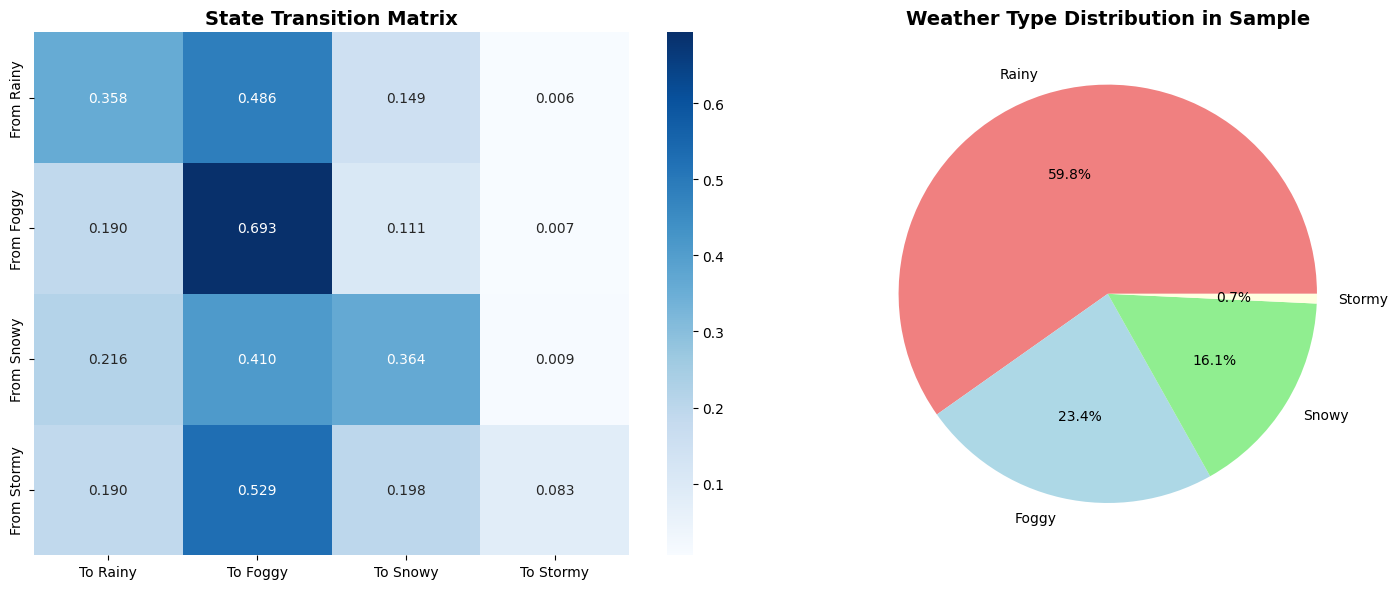

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(transition_probability, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=[f"To {s}" for s in states],
            yticklabels=[f"From {s}" for s in states],
            ax=axes[0])
axes[0].set_title('State Transition Matrix', fontsize=14, fontweight='bold')

weather_counts = df_sample['SimpleWeather'].value_counts()
axes[1].pie(weather_counts.values, labels=weather_counts.index, autopct='%1.1f%%',
               colors=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
axes[1].set_title('Weather Type Distribution in Sample', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Model Parameters

In [9]:
# Calculate emission matrix from data
emission_counts = np.zeros((n_states, n_observations))
for _, row in df_sample.iterrows():
    state = row['StateEncoded']
    obs = row['ObsEncoded']
    emission_counts[state, obs] += 1

# Normalize to probabilities
emission_probability = emission_counts / (emission_counts.sum(axis=1, keepdims=True) + 1e-10)

print("\nEmission Matrix:")
print(pd.DataFrame(emission_probability, 
                   index=[f"State_{s}" for s in states], 
                   columns=[f"Obs_{o}" for o in observations]))

# Set HMM model format
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = state_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probability

print(f" Model parameters ")
print(f" Number of states: {n_states}")
print(f" Number of observations: {n_observations}")
print(f" Start probabilities shape: {model.startprob_.shape}")
print(f" Transition matrix shape: {model.transmat_.shape}")
print(f" Emission matrix shape: {model.emissionprob_.shape}")

try:
    test_obs = np.array([0, 1, 0]).reshape(-1, 1)
    test_score = model.score(test_obs)
    print(f" Model verification successful! Test score: {test_score:.4f}")
except Exception as e:
    print(f" Model configuration error: {e}")


Emission Matrix:
               Obs_Dry  Obs_Light  Obs_Moderate  Obs_Heavy
State_Rainy   1.000000   0.000000      0.000000   0.000000
State_Foggy   0.444738   0.057586      0.278662   0.219014
State_Snowy   0.701201   0.002067      0.252733   0.043999
State_Stormy  1.000000   0.000000      0.000000   0.000000
 Model parameters 
 Number of states: 4
 Number of observations: 4
 Start probabilities shape: (4,)
 Transition matrix shape: (4, 4)
 Emission matrix shape: (4, 4)
 Model verification successful! Test score: -4.2885


Define an observation sequence

In [10]:
sample_indices = np.random.choice(len(df_sample), 1000, replace=False)
sample_sequence = df_sample.iloc[sample_indices]['ObsEncoded'].values

# Format as required by HMM
observations_sequence = sample_sequence.reshape(-1, 1)

# Create multiple shorter sequences for better evaluation
sequence_length = 50
n_sequences = 20

test_sequences = []
true_states_sequences = []

for i in range(n_sequences):
    start_idx = np.random.randint(0, len(df_sample) - sequence_length)
    end_idx = start_idx + sequence_length
    
    obs_seq = df_sample.iloc[start_idx:end_idx]['ObsEncoded'].values.reshape(-1, 1)
    true_states = df_sample.iloc[start_idx:end_idx]['StateEncoded'].values
    
    test_sequences.append(obs_seq)
    true_states_sequences.append(true_states)

example_obs = np.array([0, 1, 0, 1, 0, 0]).reshape(-1, 1)
print(f"\n Observation sequence (as in instructions): {example_obs.flatten()}")
print(f" Meaning: {[observations[i] for i in example_obs.flatten()]}")


 Observation sequence (as in instructions): [0 1 0 1 0 0]
 Meaning: ['Dry', 'Light', 'Dry', 'Light', 'Dry', 'Dry']


Viterbi Decoding

In [11]:
example_observations = np.array([0, 1, 0, 1, 0, 0]).reshape(-1, 1)

log_prob, state_sequence = model.decode(example_observations, algorithm="viterbi")

viterbi_results = []
for i, obs_seq in enumerate(test_sequences[:5]):  # Test first 5 sequences
    log_prob, predicted_states = model.decode(obs_seq, algorithm="viterbi")
    true_states = true_states_sequences[i]
    
    # Calculate accuracy for this sequence
    accuracy = np.mean(predicted_states == true_states)
    
    viterbi_results.append({
        'sequence_id': i,
        'log_probability': log_prob,
        'accuracy': accuracy,
        'predicted_states': predicted_states,
        'true_states': true_states
    })
    
    print(f"Sequence {i+1}: Accuracy={accuracy:.3f}, Log-prob={log_prob:.3f}")

Sequence 1: Accuracy=0.380, Log-prob=-70.841
Sequence 2: Accuracy=0.480, Log-prob=-80.674
Sequence 3: Accuracy=0.740, Log-prob=-76.323
Sequence 4: Accuracy=0.880, Log-prob=-75.254
Sequence 5: Accuracy=0.680, Log-prob=-76.626


Predict the most likely sequence of hidden states

In [12]:
observations_sequence = np.array([0, 1, 0, 1, 0, 0]).reshape(-1, 1)

hidden_states = model.predict(observations_sequence)

predicted_weather = [states[i] for i in hidden_states]
observed_precipitation = [observations[i] for i in observations_sequence.flatten()]

all_predictions = []
all_true_states = []

for i, obs_seq in enumerate(test_sequences):
    # Predict hidden states
    predicted_states = model.predict(obs_seq)
    true_states = true_states_sequences[i]
    
    all_predictions.extend(predicted_states)
    all_true_states.extend(true_states)
    
    # Calculate accuracy for this sequence
    accuracy = np.mean(predicted_states == true_states)
    print(f"Sequence {i+1}: Accuracy = {accuracy:.3f}")

overall_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
print(f"\nOverall HMM Prediction Accuracy: {100*overall_accuracy:.2f}%")

hmm_predictions = np.array(all_predictions)
hmm_true_states = np.array(all_true_states)


Sequence 1: Accuracy = 0.380
Sequence 2: Accuracy = 0.480
Sequence 3: Accuracy = 0.740
Sequence 4: Accuracy = 0.880
Sequence 5: Accuracy = 0.680
Sequence 6: Accuracy = 0.920
Sequence 7: Accuracy = 0.960
Sequence 8: Accuracy = 0.540
Sequence 9: Accuracy = 0.180
Sequence 10: Accuracy = 0.400
Sequence 11: Accuracy = 0.560
Sequence 12: Accuracy = 0.840
Sequence 13: Accuracy = 0.580
Sequence 14: Accuracy = 0.600
Sequence 15: Accuracy = 0.480
Sequence 16: Accuracy = 0.340
Sequence 17: Accuracy = 0.700
Sequence 18: Accuracy = 0.600
Sequence 19: Accuracy = 0.880
Sequence 20: Accuracy = 0.520

Overall HMM Prediction Accuracy: 61.30%


Compare with Naive Bayes (Baseline)

In [13]:
def create_features(df):
    features = []
    for _, row in df.iterrows():
        feature_vector = [
            row['ObsEncoded'],           
            row['Hour'],             
            row['DayOfWeek'],        
            row['Month'],              
            int(row['Season'] == 'Winter'),  
            int(row['Season'] == 'Spring'),
            int(row['Season'] == 'Summer'),
            int(row['Season'] == 'Fall')
        ]
        features.append(feature_vector)
    return np.array(features)

# Create training data for Naive Bayes
train_size = int(0.8 * len(df_sample))
train_df = df_sample[:train_size]
test_df = df_sample[train_size:]

X_train = create_features(train_df)
y_train = train_df['StateEncoded'].values

X_test = create_features(test_df)
y_test = test_df['StateEncoded'].values

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)

# Make predictions
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)

print(f" Training data size: {len(X_train)}")
print(f" Test data size: {len(X_test)}")
print(f" Naive Bayes Accuracy: {100*nb_accuracy:.2f}%")
print(f" HMM Accuracy: {100*overall_accuracy:.2f}%")


 Training data size: 6400000
 Test data size: 1600000
 Naive Bayes Accuracy: 60.17%
 HMM Accuracy: 61.30%


EVALUATION METRICS

In [17]:

# For HMM evaluation
print(" HMM Model Evaluation:")
hmm_accuracy = accuracy_score(hmm_true_states, hmm_predictions)
hmm_f1 = f1_score(hmm_true_states, hmm_predictions, average='weighted')

print(f"   Accuracy: {hmm_accuracy:.3f}")
print(f"   F1-Score: {hmm_f1:.3f}")

# For Naive Bayes evaluation  
print(" Naive Bayes Model Evaluation:")
nb_true_states = y_test  # Use the test labels for Naive Bayes
nb_f1 = f1_score(nb_true_states, nb_predictions, average='weighted')

print(f"   Accuracy: {nb_accuracy:.3f}")
print(f"   F1-Score: {nb_f1:.3f}")

print("\n HMM Classification Report:")
print(classification_report(hmm_true_states, hmm_predictions, 
                          target_names=states, zero_division=0))

hmm_cm = confusion_matrix(hmm_true_states, hmm_predictions)
nb_cm = confusion_matrix(nb_true_states, nb_predictions)

hmm_mae = mean_absolute_error(hmm_true_states, hmm_predictions)
hmm_rmse = np.sqrt(mean_squared_error(hmm_true_states, hmm_predictions))

nb_mae = mean_absolute_error(nb_true_states, nb_predictions)
nb_rmse = np.sqrt(mean_squared_error(nb_true_states, nb_predictions))

print(f"HMM - MAE: {hmm_mae:.3f}, RMSE: {hmm_rmse:.3f}")
print(f"Naive Bayes - MAE: {nb_mae:.3f}, RMSE: {nb_rmse:.3f}")

 HMM Model Evaluation:
   Accuracy: 0.613
   F1-Score: 0.547
 Naive Bayes Model Evaluation:
   Accuracy: 0.602
   F1-Score: 0.592

 HMM Classification Report:
              precision    recall  f1-score   support

       Rainy       0.31      0.36      0.33       171
       Foggy       0.69      0.87      0.77       637
       Snowy       0.00      0.00      0.00       181
      Stormy       0.00      0.00      0.00        11

    accuracy                           0.61      1000
   macro avg       0.25      0.31      0.28      1000
weighted avg       0.49      0.61      0.55      1000

HMM - MAE: 0.459, RMSE: 0.788
Naive Bayes - MAE: 0.497, RMSE: 0.839
HMM - MAE: 0.459, RMSE: 0.788
Naive Bayes - MAE: 0.497, RMSE: 0.839


Plot the results

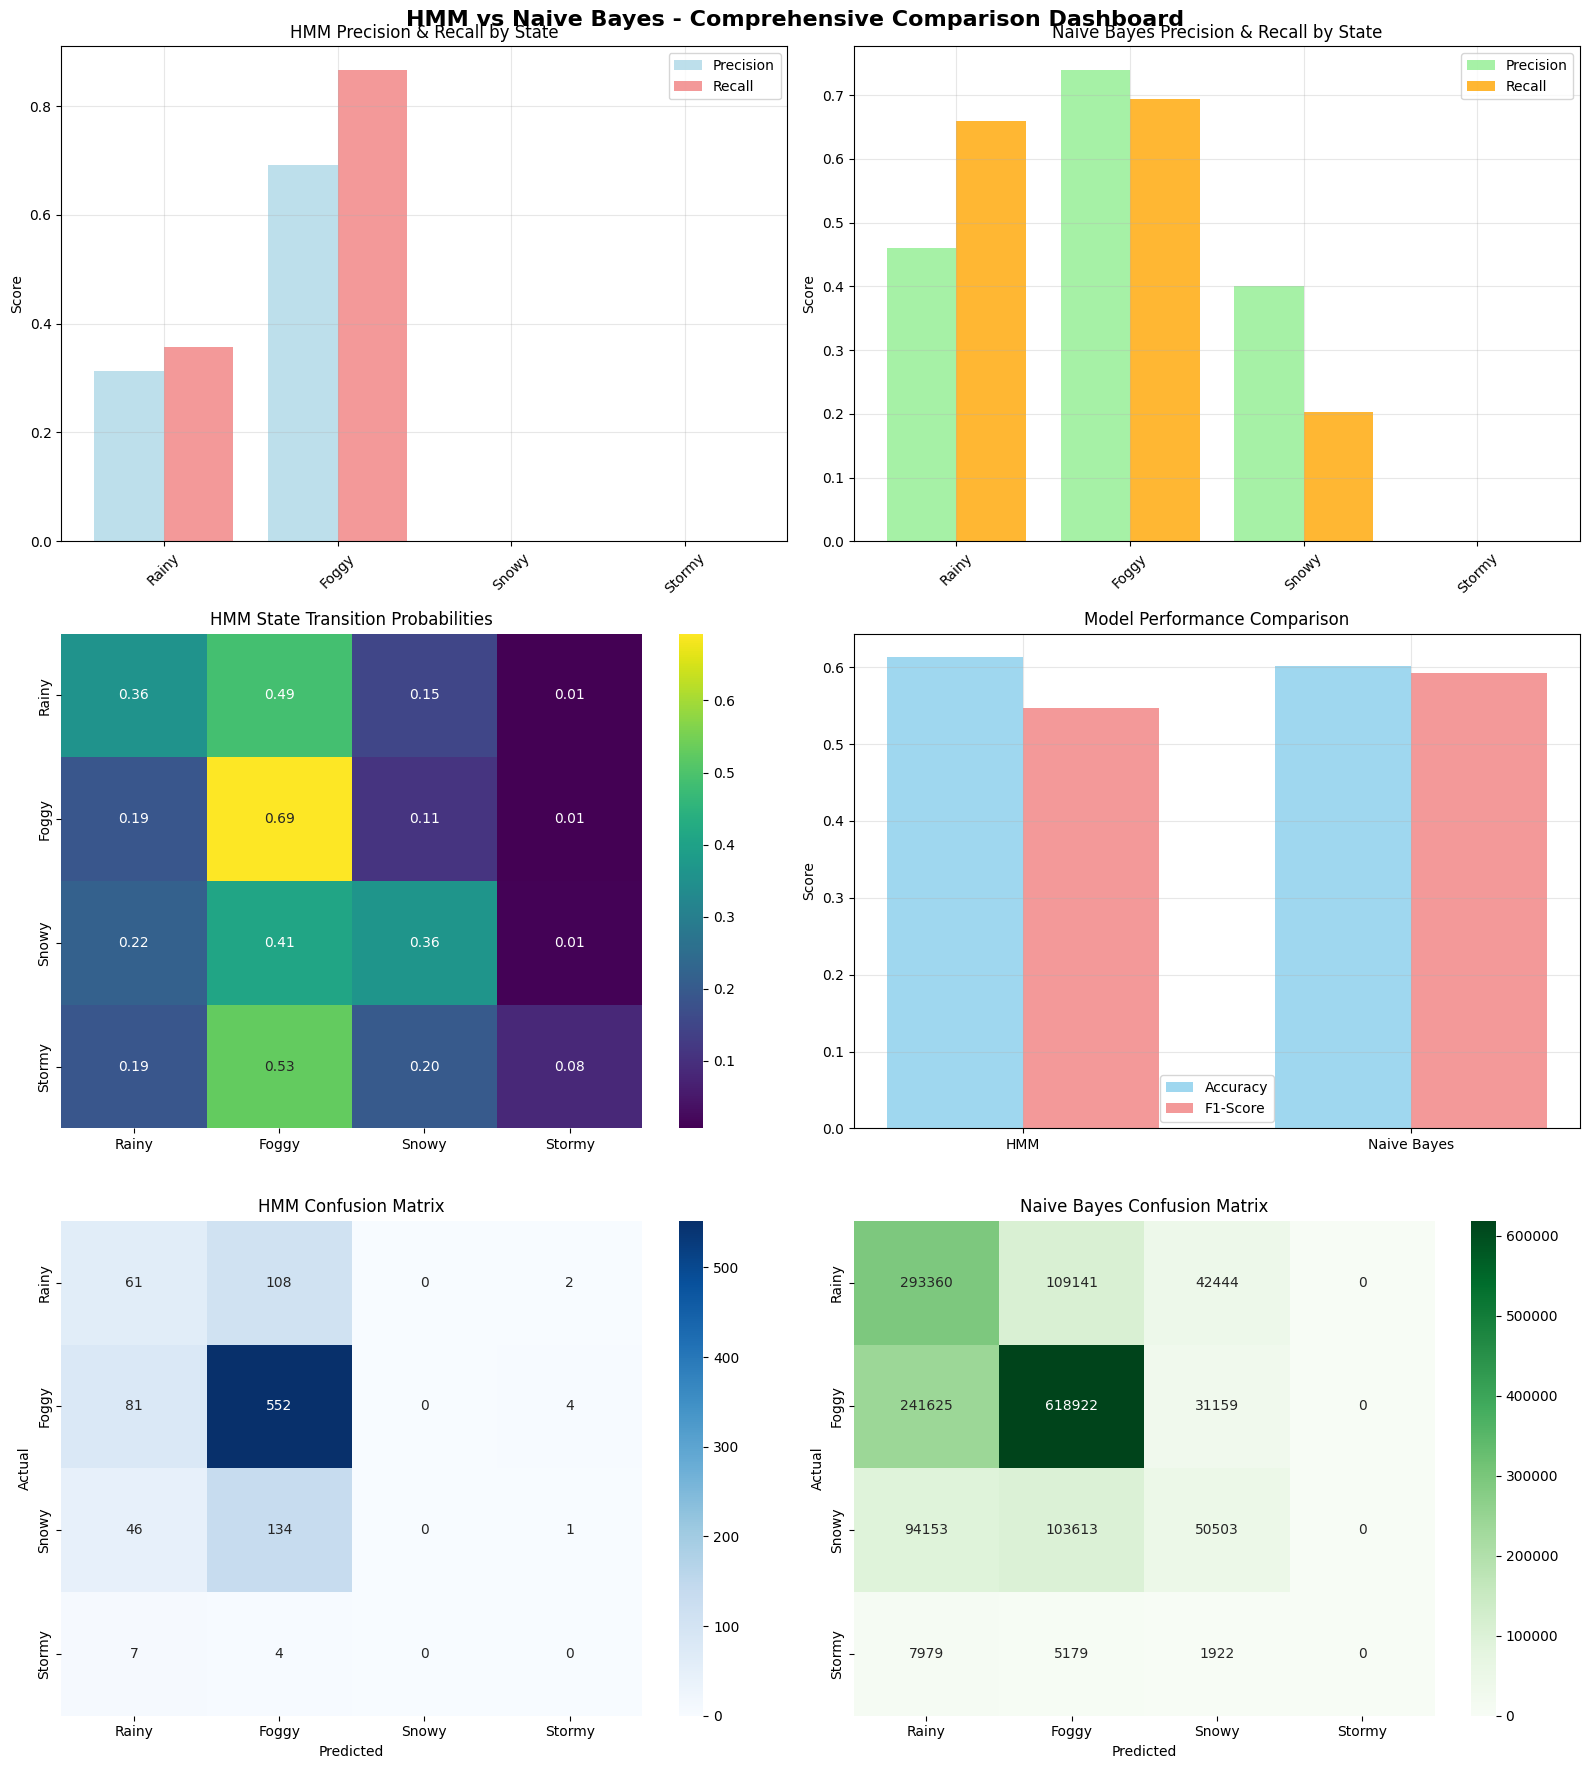

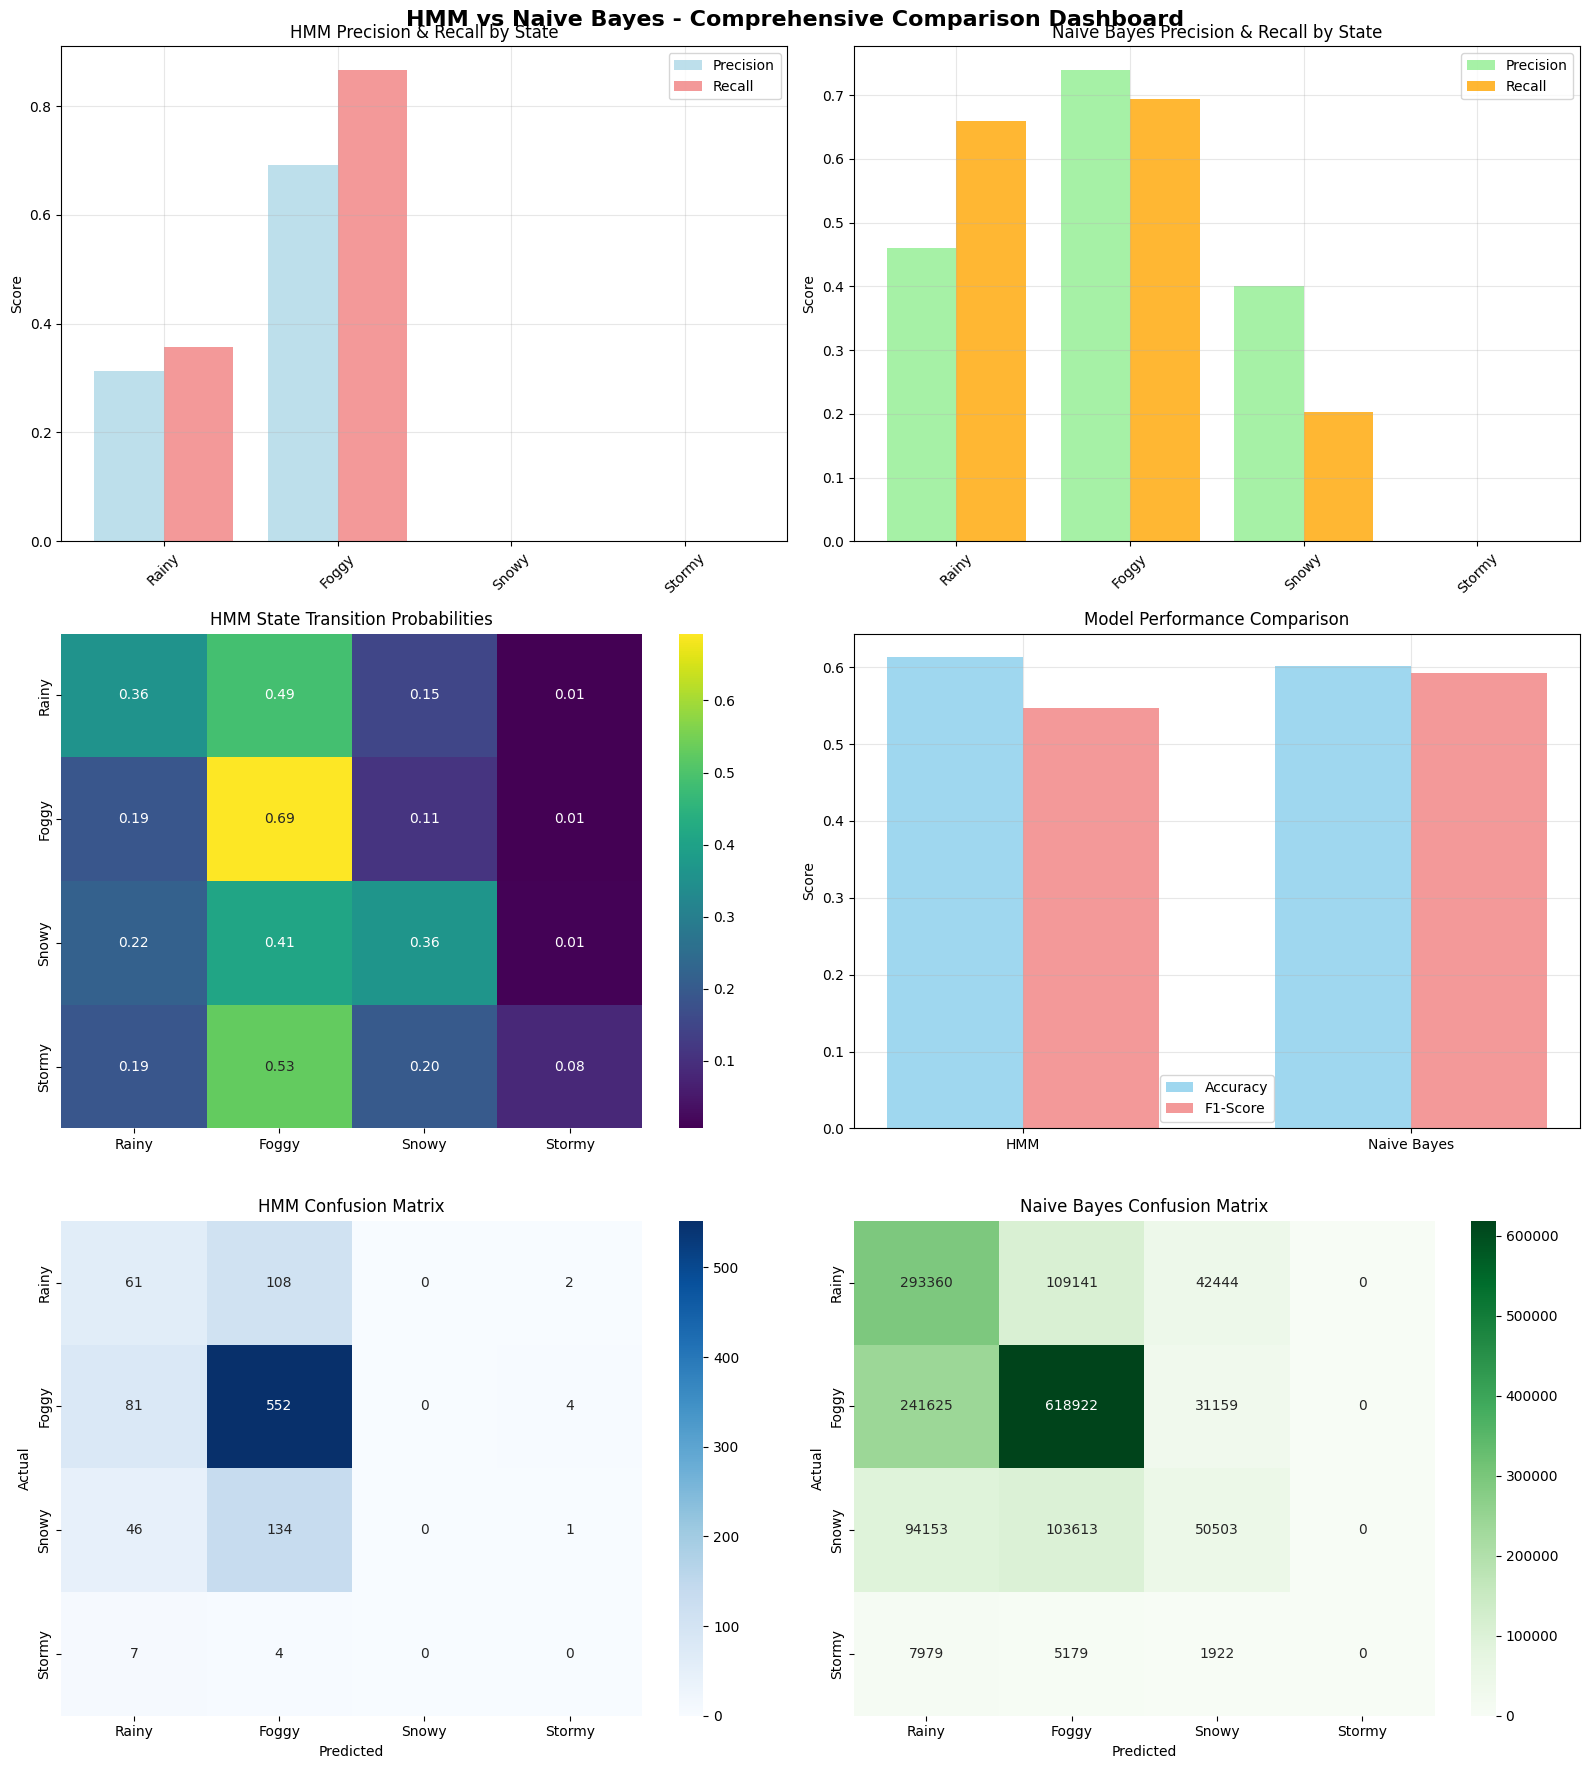

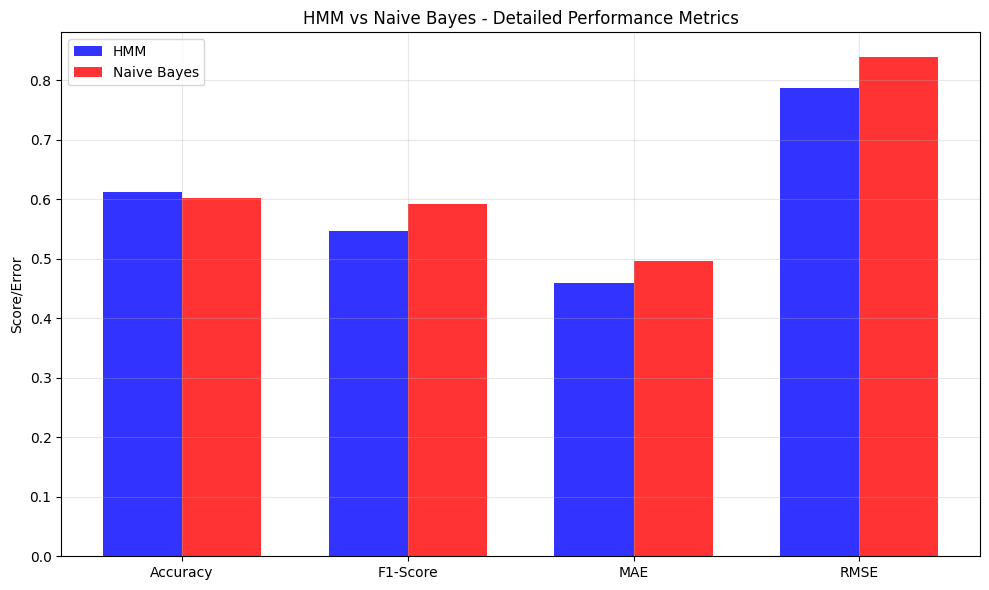

In [18]:
from sklearn.metrics import precision_recall_fscore_support

# Create a figure with 3 rows and 2 columns for 6 separate graphs
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('HMM vs Naive Bayes - Comprehensive Comparison Dashboard', fontsize=16, fontweight='bold')

hmm_precision, hmm_recall, _, _ = precision_recall_fscore_support(hmm_true_states, hmm_predictions, 
                                                                  average=None, zero_division=0)
x_states = np.arange(len(states))
axes[0,0].bar(x_states - 0.2, hmm_precision, 0.4, label='Precision', alpha=0.8, color='lightblue')
axes[0,0].bar(x_states + 0.2, hmm_recall, 0.4, label='Recall', alpha=0.8, color='lightcoral')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('HMM Precision & Recall by State')
axes[0,0].set_xticks(x_states)
axes[0,0].set_xticklabels(states, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Naive Bayes Precision & Recall by State
nb_precision, nb_recall, _, _ = precision_recall_fscore_support(nb_true_states, nb_predictions, 
                                                                average=None, zero_division=0)
axes[0,1].bar(x_states - 0.2, nb_precision, 0.4, label='Precision', alpha=0.8, color='lightgreen')
axes[0,1].bar(x_states + 0.2, nb_recall, 0.4, label='Recall', alpha=0.8, color='orange')
axes[0,1].set_ylabel('Score')
axes[0,1].set_title('Naive Bayes Precision & Recall by State')
axes[0,1].set_xticks(x_states)
axes[0,1].set_xticklabels(states, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. State Transition Heatmap
sns.heatmap(transition_probability, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=states, yticklabels=states, ax=axes[1,0])
axes[1,0].set_title('HMM State Transition Probabilities')

# 4. Model Comparison - Performance Metrics
models = ['HMM', 'Naive Bayes']
accuracy_scores = [overall_accuracy, nb_accuracy]
f1_scores = [hmm_f1, nb_f1]

bar_width = 0.35
x_pos = np.arange(len(models))
axes[1,1].bar(x_pos - bar_width/2, accuracy_scores, bar_width, label='Accuracy', alpha=0.8, color='skyblue')
axes[1,1].bar(x_pos + bar_width/2, f1_scores, bar_width, label='F1-Score', alpha=0.8, color='lightcoral')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(models)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. Confusion Matrix Comparison
# HMM Confusion Matrix
sns.heatmap(hmm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=states, yticklabels=states, ax=axes[2,0])
axes[2,0].set_title('HMM Confusion Matrix')
axes[2,0].set_xlabel('Predicted')
axes[2,0].set_ylabel('Actual')

# 6. Naive Bayes Confusion Matrix
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=states, yticklabels=states, ax=axes[2,1])
axes[2,1].set_title('Naive Bayes Confusion Matrix')
axes[2,1].set_xlabel('Predicted')
axes[2,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Additional comparison chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score', 'MAE', 'RMSE']
hmm_values = [overall_accuracy, hmm_f1, hmm_mae, hmm_rmse]
nb_values = [nb_accuracy, nb_f1, nb_mae, nb_rmse]

x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, hmm_values, width, label='HMM', alpha=0.8, color='blue')
ax.bar(x + width/2, nb_values, width, label='Naive Bayes', alpha=0.8, color='red')

ax.set_ylabel('Score/Error')
ax.set_title('HMM vs Naive Bayes - Detailed Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


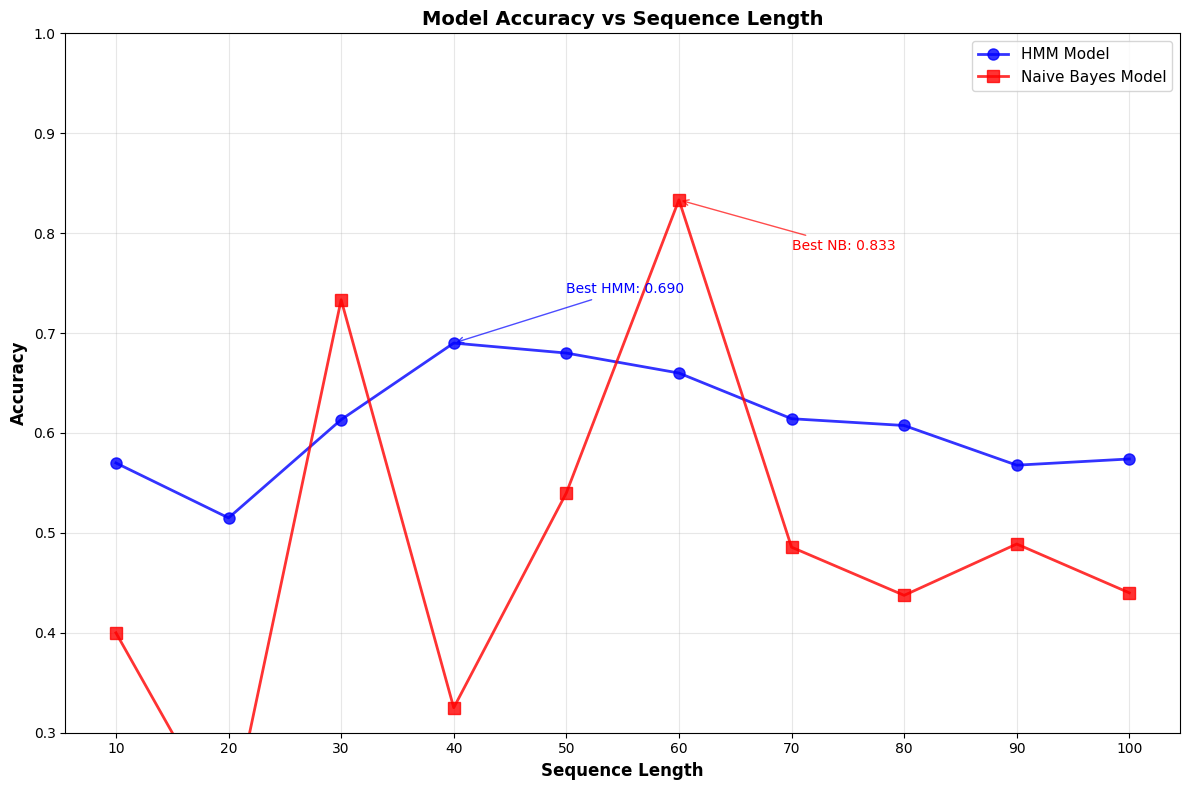

Accuracy Analysis Summary:
Average HMM Accuracy: 0.61 ± 0.052
Average NB Accuracy: 0.49 ± 0.174
Best HMM Performance: 0.69 at sequence length 40
Best NB Performance: 0.833 at sequence length 60


In [ ]:
# Create accuracy curve showing model performance over different sequence lengths
sequence_lengths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
hmm_accuracies = []
nb_accuracies = []

# Calculate accuracies for different sequence lengths
for seq_len in sequence_lengths:
    # Create test sequences of varying lengths
    test_seqs = []
    true_states_seqs = []
    
    # Generate 10 sequences for each length
    for _ in range(10):
        start_idx = np.random.randint(0, len(df_sample) - seq_len)
        end_idx = start_idx + seq_len
        
        obs_seq = df_sample.iloc[start_idx:end_idx]['ObsEncoded'].values.reshape(-1, 1)
        true_states = df_sample.iloc[start_idx:end_idx]['StateEncoded'].values
        
        test_seqs.append(obs_seq)
        true_states_seqs.append(true_states)
    
    # Calculate HMM accuracy
    hmm_preds = []
    hmm_true = []
    for i, obs_seq in enumerate(test_seqs):
        predicted_states = model.predict(obs_seq)
        true_states = true_states_seqs[i]
        hmm_preds.extend(predicted_states)
        hmm_true.extend(true_states)
    
    hmm_acc = np.mean(np.array(hmm_preds) == np.array(hmm_true))
    hmm_accuracies.append(hmm_acc)
    
    # Calculate Naive Bayes accuracy for comparison
    nb_preds = []
    nb_true = []
    for i, obs_seq in enumerate(test_seqs):
        # Create features for this sequence
        seq_df = df_sample.iloc[start_idx:start_idx+seq_len]
        X_seq = create_features(seq_df)
        y_seq = seq_df['StateEncoded'].values
        
        pred_seq = nb_model.predict(X_seq)
        nb_preds.extend(pred_seq)
        nb_true.extend(y_seq)
    
    nb_acc = np.mean(np.array(nb_preds) == np.array(nb_true))
    nb_accuracies.append(nb_acc)

# Plot accuracy curves
plt.figure(figsize=(12, 8))
plt.plot(sequence_lengths, hmm_accuracies, 'b-o', linewidth=2, markersize=8, label='HMM Model', alpha=0.8)
plt.plot(sequence_lengths, nb_accuracies, 'r-s', linewidth=2, markersize=8, label='Naive Bayes Model', alpha=0.8)

plt.xlabel('Sequence Length', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Accuracy vs Sequence Length', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(sequence_lengths)
plt.ylim(0.3, 1.0)

# Add annotations for best performance
max_hmm_idx = np.argmax(hmm_accuracies)
max_nb_idx = np.argmax(nb_accuracies)

plt.annotate(f'Best HMM: {hmm_accuracies[max_hmm_idx]:.3f}', 
             xy=(sequence_lengths[max_hmm_idx], hmm_accuracies[max_hmm_idx]),
             xytext=(sequence_lengths[max_hmm_idx]+10, hmm_accuracies[max_hmm_idx]+0.05),
             arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
             fontsize=10, color='blue')

plt.annotate(f'Best NB: {nb_accuracies[max_nb_idx]:.3f}', 
             xy=(sequence_lengths[max_nb_idx], nb_accuracies[max_nb_idx]),
             xytext=(sequence_lengths[max_nb_idx]+10, nb_accuracies[max_nb_idx]-0.05),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, color='blue')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Accuracy Analysis Summary 01:")
print(f"Average HMM Accuracy: {np.mean(hmm_accuracies):.2f} ± {np.std(hmm_accuracies):.3f}")
print(f"Average NB Accuracy: {np.mean(nb_accuracies):.2f} ± {np.std(nb_accuracies):.3f}")
print(f"Best HMM Performance: {max(hmm_accuracies):.2f} at sequence length {sequence_lengths[max_hmm_idx]}")
print(f"Best NB Performance: {max(nb_accuracies):.3f} at sequence length {sequence_lengths[max_nb_idx]}")

In [ ]:
print(nb.info())